# Dropout
Dropout [1] est une technique de régularisation qui consiste à forcer aléatoirement à zéro certains neurones lors de la propagation avant. Pour cet exercice, vous serez appelé à coder une couche de dropout et de l'incorporer à votre réseau pleinement connecté.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the ift725 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout: propagation avant
Dans le fichier `ift725/layers.py`, codez la propagation avant du dropout. Puisque dropout se comporte différemment en entraînement qu'en test, assurez-vous que les deux modes fonctionnent bien.

Exécutez la cellule que voici et assurez-vous que la moyenne de out_train soit la même que out_test.

NOTE : vous devez implémenter du "inverse dropout".  Pour plus de détail, voir https://deepnotes.io/dropout

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out_train, _ = forward_inverted_dropout(x, {'mode': 'train', 'p': p})
  out_test, _ = forward_inverted_dropout(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out_train.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out_train == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.3
Mean of input:  9.997935424982163
Mean of train-time output:  10.001039682744386
Mean of test-time output:  9.997935424982163
Fraction of train-time output set to zero:  0.29984
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  9.997935424982163
Mean of train-time output:  9.987584672808401
Mean of test-time output:  9.997935424982163
Fraction of train-time output set to zero:  0.6003
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  9.997935424982163
Mean of train-time output:  9.961567723186745
Mean of test-time output:  9.997935424982163
Fraction of train-time output set to zero:  0.750876
Fraction of test-time output set to zero:  0.0



# Dropout: rétro-propagation
Dans le fichier `ift725/layers.py`, codez la rétro-propagation du dropout. Vous pourrez par la suite tester votre code avec la cellule que voici.

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = forward_inverted_dropout(x, dropout_param)
dx = backward_inverted_dropout(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: forward_inverted_dropout(xx, dropout_param)[0], x, dout)

# Error should be below 1e-10
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8929074546591192e-11


# Réseau multi-couches avec Dropout
Dans le fichier `ift725/classifiers/fc_net.py`, modifiez votre code afin d'y incorporer dropout. Plus particulièrement, si le constructeur du réseau reçoit une valeur non nulle pour le paramètre `dropout`, le réseau devrait ajouter du dropout après chaque ReLU. Vous pouvez tester votre code avec la cellule que voici.

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

    
  # Error should be below 1e-5
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.3051948273987857
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10

Running check with dropout =  0.25
Initial loss:  2.29898614757146
W1 relative error: 9.74e-07
W2 relative error: 5.07e-08
W3 relative error: 3.04e-08
b1 relative error: 2.01e-08
b2 relative error: 1.90e-09
b3 relative error: 1.30e-10

Running check with dropout =  0.5
Initial loss:  2.302437587710995
W1 relative error: 4.55e-08
W2 relative error: 2.97e-08
W3 relative error: 4.34e-07
b1 relative error: 1.87e-08
b2 relative error: 5.05e-09
b3 relative error: 8.01e-11



# Expérimentation
Ici nous entrainerons 2 réseaux de neurones avec 500 données: l'un utilisera du dropout et l'autre non. Nous pourrons alors visualiser les justesses obtenues en entraînement et en validation.

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNeuralNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 8.596245
(Epoch 0 / 25) train acc: 0.224000; val_acc: 0.183000
(Epoch 1 / 25) train acc: 0.382000; val_acc: 0.219000
(Epoch 2 / 25) train acc: 0.484000; val_acc: 0.248000
(Epoch 3 / 25) train acc: 0.620000; val_acc: 0.274000
(Epoch 4 / 25) train acc: 0.654000; val_acc: 0.245000
(Epoch 5 / 25) train acc: 0.726000; val_acc: 0.280000
(Epoch 6 / 25) train acc: 0.788000; val_acc: 0.301000
(Epoch 7 / 25) train acc: 0.816000; val_acc: 0.261000
(Epoch 8 / 25) train acc: 0.840000; val_acc: 0.272000
(Epoch 9 / 25) train acc: 0.910000; val_acc: 0.289000
(Epoch 10 / 25) train acc: 0.932000; val_acc: 0.292000
(Epoch 11 / 25) train acc: 0.966000; val_acc: 0.262000
(Epoch 12 / 25) train acc: 0.940000; val_acc: 0.274000
(Epoch 13 / 25) train acc: 0.956000; val_acc: 0.280000
(Epoch 14 / 25) train acc: 0.926000; val_acc: 0.259000
(Epoch 15 / 25) train acc: 0.966000; val_acc: 0.281000
(Epoch 16 / 25) train acc: 0.982000; val_acc: 0.297000
(Epoch 17 / 25) train acc: 0.976000; v

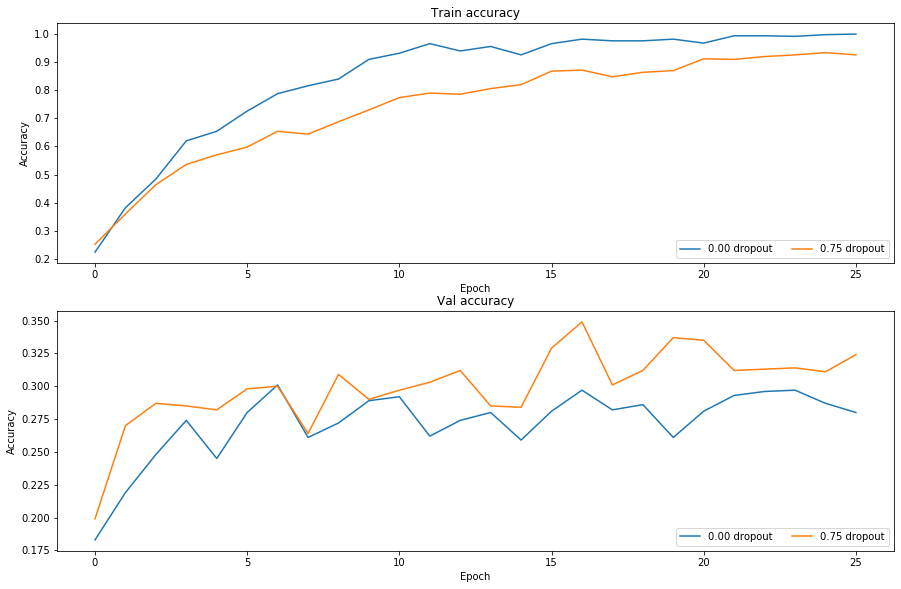

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, '-', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, '-', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Question
Expliquez la conclusion que l'on peut tirer de ces deux courbes.

## Votre réponse : ...
"After applying dropout, overfitting hasn't decreased much, which suggests that dropout can't solve the problem of overfitting without using another strong regularizer." à vérifier